In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [2]:
data_dir = '../data'
fn = f'{data_dir}/MWDD-export-preprocessed.csv'
df = pd.read_csv(fn)

df.dtypes

wdid                object
icrsra              object
icrsdec             object
spectype            object
teff               float64
logg               float64
mass               float64
logL               float64
age                float64
Dpc                float64
ismag                 bool
su                 float64
Dsu                float64
sg                 float64
Dsg                float64
sr                 float64
Dsr                float64
si                 float64
Dsi                float64
sz                 float64
Dsz                float64
EBmV               float64
spectype_simple     object
dtype: object

In [3]:
filters = ['su', 'sg', 'sr', 'si', 'sz']
err_filters = [f'D{f}' for f in filters]

physicals = ['teff', 'logg', 'mass']
binaries = ['ismag']

col_input = [*physicals, *filters, *binaries]

In [4]:
df.value_counts('spectype_simple') / len(df)

spectype_simple
DA    0.843261
DB    0.066736
DC    0.052952
DZ    0.021963
DQ    0.011601
DO    0.003487
Name: count, dtype: float64

80% of the data is classified as a DA WD. To not overwhelm our model with DA objects, we'll split the data into DA vs. non-DA

In [5]:
df['DA'] = df['spectype_simple'] == 'DA'

First we need to transform and scale our input, and setup the model. We'll do a grid search (with cross-validation) to find some reasonable model parameters.

In [6]:
transform_filters = MinMaxScaler()
transform_physicals = MinMaxScaler()
transform_binaries = Binarizer()

transformer = ColumnTransformer([
    ('filters', transform_filters, filters),
    ('physicals', transform_physicals, physicals),
    ('binaries', transform_binaries, binaries),
], remainder='passthrough')

rng_seed = 1
model_params = {
    'random_state': rng_seed,
}
param_grid = {
    'learning_rate': [0.1, 0.3, 0.05],
    'max_depth': [None, 50, 75],
}

pipeline = Pipeline([
    ('transformer', transformer),
    ('model', GridSearchCV(
            HistGradientBoostingClassifier(**model_params),
            param_grid=param_grid,
            cv=2,
            refit=True,
        )
    )
])

First do DA vs. non-DA:

In [7]:
X = df[col_input]
y = df['DA']

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=rng_seed)

pipeline.fit(X_train, y_train)
y_predict = pipeline.predict(X_test)

We can make a confusion matrix and get some statistics such as precision and recall:

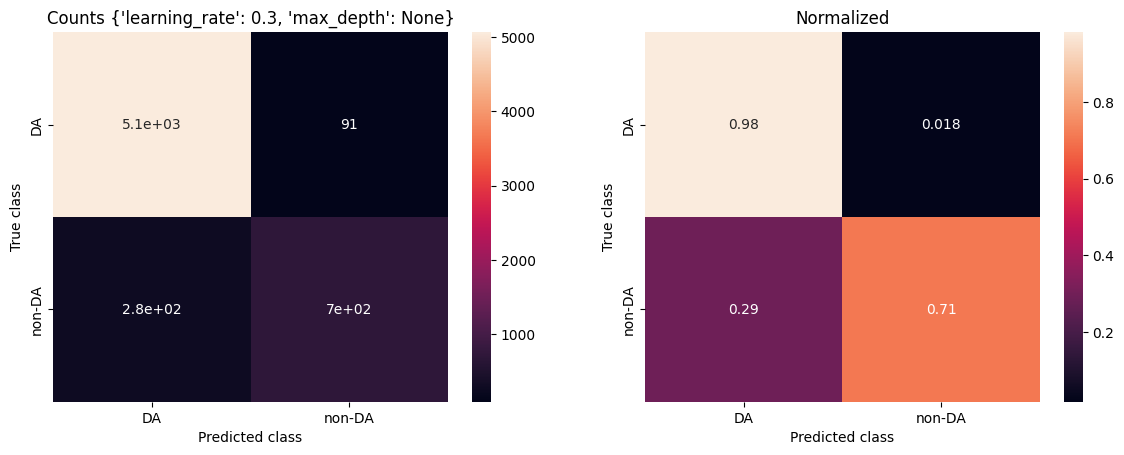

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4.8))

cm = confusion_matrix(y_test, y_predict, labels=[1, 0])
sns.heatmap(cm, ax=ax[0], annot=True)

cm = confusion_matrix(y_test, y_predict, labels=[1, 0], normalize='true')
sns.heatmap(cm, ax=ax[1], annot=True)

[_ax.set_xlabel('Predicted class') for _ax in ax]
[_ax.set_ylabel('True class') for _ax in ax]
[_ax.set_xticklabels(['DA', 'non-DA']) for _ax in ax]
[_ax.set_yticklabels(['DA', 'non-DA']) for _ax in ax]

ax[0].set_title(f'Counts {pipeline["model"].best_params_}')
ax[1].set_title(f'Normalized')

plt.show()

In [9]:
stats = precision_recall_fscore_support(y_test, y_predict)
df_stats = pd.DataFrame(stats, index=['precision', 'recall', 'fscore', 'support'], columns=['DA', 'non-DA'])
df_stats

,DA,non-DA
precision,0.884224,0.946749
recall,0.709184,0.982358
fscore,0.787089,0.964225
support,980.000000,5158.000000


Now classify non-DAs separately:

In [10]:
df_nonDA = df[~df['DA']]
X = df_nonDA[col_input]
y = df_nonDA['spectype_simple']

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=rng_seed)

pipeline.fit(X_train, y_train)
y_predict = pipeline.predict(X_test)

We can do the same evaluation as above:

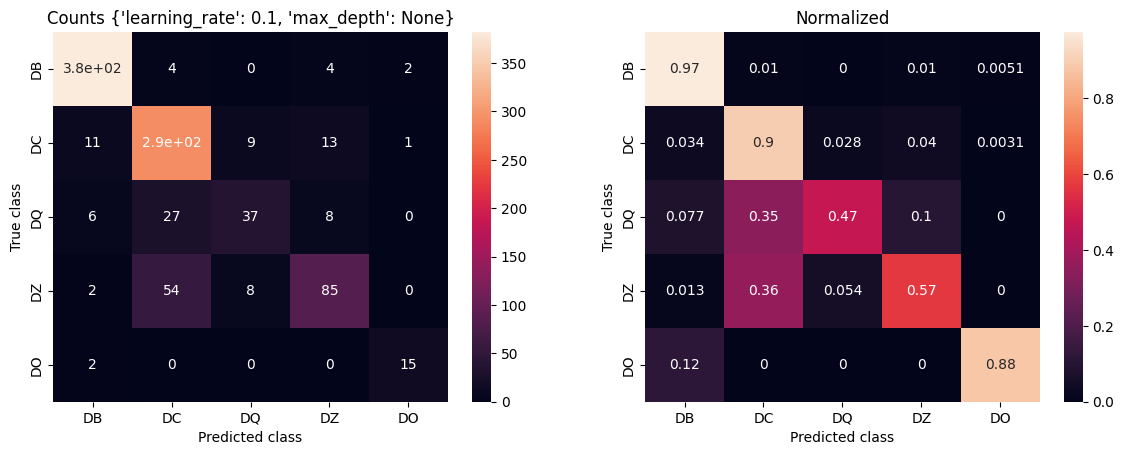

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4.8))

classes = ['DB', 'DC', 'DQ', 'DZ', 'DO']

cm = confusion_matrix(y_test, y_predict, labels=classes)
sns.heatmap(cm, ax=ax[0], annot=True)

cm = confusion_matrix(y_test, y_predict, labels=classes, normalize='true')
sns.heatmap(cm, ax=ax[1], annot=True)

[_ax.set_xlabel('Predicted class') for _ax in ax]
[_ax.set_ylabel('True class') for _ax in ax]
[_ax.set_xticklabels(classes) for _ax in ax]
[_ax.set_yticklabels(classes) for _ax in ax]

ax[0].set_title(f'Counts {pipeline["model"].best_params_}')
ax[1].set_title('Normalized')

plt.show()

In [12]:
stats = precision_recall_fscore_support(y_test, y_predict)
df_stats = pd.DataFrame(stats, index=['precision', 'recall', 'fscore', 'support'], columns=classes)
df_stats

,DB,DC,DQ,DZ,DO
precision,0.947891,0.774536,0.833333,0.685185,0.772727
recall,0.974490,0.895706,0.882353,0.474359,0.570470
fscore,0.961006,0.830725,0.857143,0.560606,0.656371
support,392.000000,326.000000,17.000000,78.000000,149.000000
